In [1]:
import sqlite3

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from src.solver.TSP_LKH_Solver import TSP_LKH_Solver

pd.options.display.max_columns = 999
conn = sqlite3.connect("_archive/7/CEPS2.db")

In [2]:
solver_class = TSP_LKH_Solver
solver_class.MAX_COST

100.0

In [3]:
query = """
select 
    results.cost,
    solvers_f64.*,
    instances.*
from results
join instances on results.instance_id = instances.id
join solvers_f64 on results.solver_id = solvers_f64.id
WHERE comment in ('initialization', 'configuration')
"""

df = pd.read_sql_query(query, conn).drop(columns="id")

In [4]:
y = df["cost"].to_numpy()
X = df.drop(columns="cost").to_numpy()
pd.Series(y < solver_class.MAX_COST).value_counts(normalize=True)

False    0.86336
True     0.13664
dtype: float64

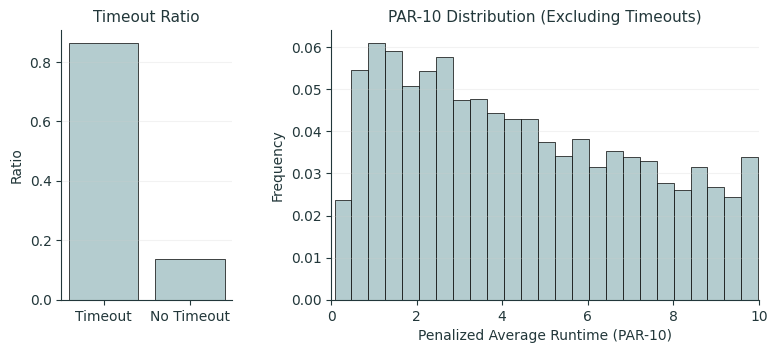

In [5]:
FONT_COLOR = "#22373a"
FILL_COLOR = "#b4cccf"

import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["grid.color"] = "#cccccc"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5), width_ratios=[1.2, 3])

y_timeout = y == solver_class.MAX_COST
timeout_percentage = y_timeout.mean() * 100
ax1.bar(["Timeout", "No Timeout"], [timeout_percentage / 100, 1 - timeout_percentage / 100], edgecolor="black", lw=0.5, color=FILL_COLOR)
ax1.set_ylabel("Ratio", color=FONT_COLOR)
ax1.set_title("Timeout Ratio", fontsize=11, color=FONT_COLOR)
ax1.yaxis.grid(True)
ax1.xaxis.grid(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_color(FONT_COLOR)
ax1.spines["bottom"].set_color(FONT_COLOR)
ax1.tick_params(axis='x', colors=FONT_COLOR)
ax1.tick_params(axis='y', colors=FONT_COLOR)

y_score = y[y < solver_class.MAX_COST]
ax2.hist(y_score, bins=25, edgecolor="black", lw=0.5, weights=np.ones(len(y_score)) / len(y_score), color=FILL_COLOR)
ax2.set_xlim(0, 10)
ax2.set_ylabel("Frequency", color=FONT_COLOR)
ax2.yaxis.grid(True)
ax2.xaxis.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_color(FONT_COLOR)
ax2.spines["bottom"].set_color(FONT_COLOR)
ax2.set_title("PAR-10 Distribution (Excluding Timeouts)", fontsize=11, color=FONT_COLOR)
ax2.set_xlabel("Penalized Average Runtime (PAR-10)", color=FONT_COLOR)
ax2.tick_params(axis='x', colors=FONT_COLOR)
ax2.tick_params(axis='y', colors=FONT_COLOR)

plt.subplots_adjust(wspace=0.33)
plt.savefig("cost_distribution.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [30]:
y_timeout = y != solver_class.MAX_COST

X_train, X_test, y_train, y_test = train_test_split(X, y_timeout, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((25735, 137), (6434, 137))

In [6]:
# # timeout

# param_dist = {
#     "max_features": ["sqrt", "log2", 0.4, 0.6, 0.8, 1.0],
#     "min_samples_split": [2, 5, 10, 15, 20, 30, 40, 50],
#     "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
#     "max_depth": [None, 10, 20, 30, 40, 50],
#     "class_weight": ["balanced", "balanced_subsample", None],
# }

# rf = RandomForestClassifier(random_state=0, n_estimators=50)

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=100,
#     cv=3,
#     scoring='f1',
#     random_state=0,
#     n_jobs=-1,
# )

# random_search.fit(X_train, y_train)

# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best score: {random_search.best_score_:.2f}")
# random_search.best_estimator_

TRAIN
              precision    recall  f1-score   support

       False       0.99      0.90      0.94     21200
        True       0.67      0.94      0.78      4535

    accuracy                           0.91     25735
   macro avg       0.83      0.92      0.86     25735
weighted avg       0.93      0.91      0.91     25735

TEST
              precision    recall  f1-score   support

       False       0.94      0.88      0.91      5266
        True       0.57      0.76      0.65      1168

    accuracy                           0.85      6434
   macro avg       0.76      0.82      0.78      6434
weighted avg       0.88      0.85      0.86      6434



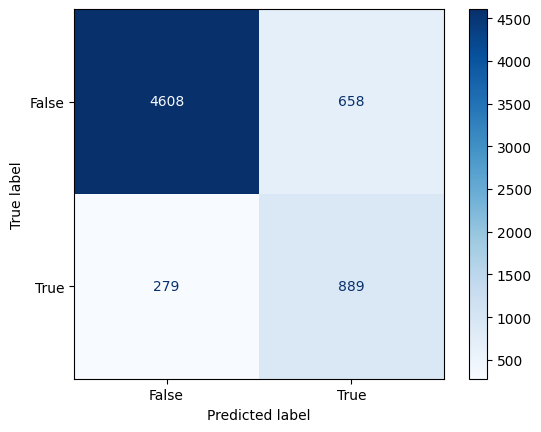

In [31]:

rf_classifier = RandomForestClassifier(
    class_weight="balanced",
    max_depth=50,
    max_features=0.4,
    min_samples_leaf=8,
    min_samples_split=20,
    n_estimators=100,
    random_state=0,
    n_jobs=10,
)
rf_classifier.fit(X_train, y_train)
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)
print("TRAIN")
print(classification_report(y_train, y_train_pred))
print("TEST")
print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")

In [8]:
# score
X_score = X[y < solver_class.MAX_COST]
y_score = y[y < solver_class.MAX_COST]
y_score.shape

(6343,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_score, y_score, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((5074, 137), (1269, 137))

In [10]:
# param_dist = {
#     "max_features": ["sqrt", "log2", 0.4, 0.6, 0.8, 1.0],
#     "min_samples_split": [2, 5, 10, 15, 20, 30, 40, 50],
#     "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64],
#     "max_depth": [None, 10, 20, 30, 40, 50],
# }

# rf = RandomForestRegressor(random_state=0, n_estimators=50)

# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=300,
#     cv=3,
#     verbose=2,
#     random_state=0,
#     n_jobs=-1,
# )

# random_search.fit(X_train, y_train)

# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best score: {random_search.best_score_:.2f}")
# random_search.best_estimator_

In [11]:
rf_regressor = RandomForestRegressor(
    max_depth=20,
    max_features=0.4,
    min_samples_leaf=8,
    min_samples_split=40,
    n_estimators=50,
    random_state=0,
)
rf_regressor = rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Train MSE: {train_mse:.2f}, Train MAE: {train_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test MSE: {test_mse:.2f}, Test MAE: {test_mae:.2f}")

Train RMSE: 2.21, Train MSE: 4.86, Train MAE: 1.84
Test RMSE: 2.56, Test MSE: 6.57, Test MAE: 2.13


<Axes: ylabel='Frequency'>

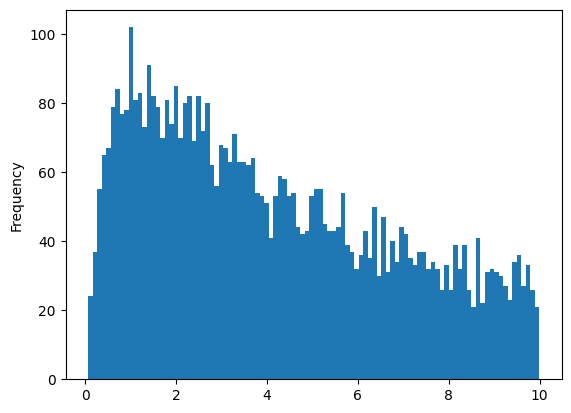

In [12]:
pd.Series(y_train).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

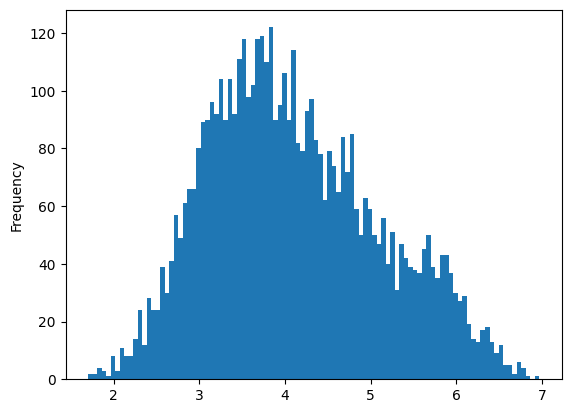

In [13]:
pd.Series(y_train_pred).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

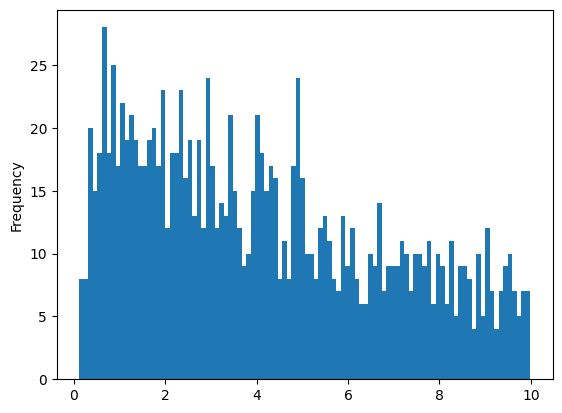

In [14]:
pd.Series(y_test).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

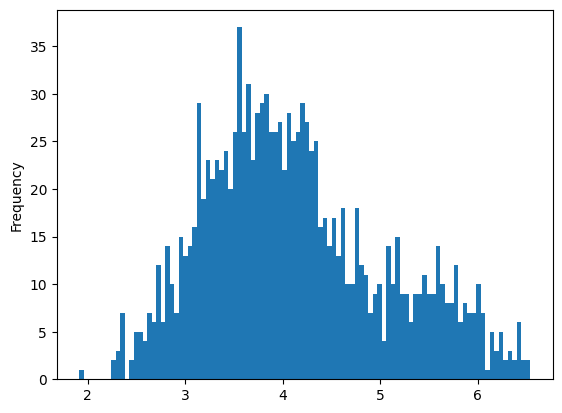

In [15]:
pd.Series(y_test_pred).plot.hist(bins=100)

In [23]:
is_timeout = ~rf_classifier.predict(X)[0]
if is_timeout:
    costs_pred = solver_class.MAX_COST
if not is_timeout:
    costs_pred = rf_regressor.predict(X)[0]

costs_pred
# costs_pred = rf_regressor.predict(X)
# costs_pred = np.where(is_timeout, solver_class.MAX_COST, costs_pred)
# costs_pred

100.0